In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [37]:
import rasterio
import numpy as np
import pandas as pd

# Open raster
with rasterio.open("F:/Biomass tiffs/Biomass modeling/Georgia/All_trend/ALLGA_LOG_sig_1984to2023.tif") as src:
    arr = src.read(1)  # read first band
    transform = src.transform
    bounds = src.bounds

# Get row/col indices for non-NaN pixels
rows, cols = np.where(~np.isnan(arr))
values = arr[rows, cols]

# Convert pixel row/col -> lat/lon (WGS84)
lons, lats = rasterio.transform.xy(transform, rows, cols) ##WAS ORIGINALL lats, lons = ..., but that mixed up lat and long
lats = np.array(lats)
lons = np.array(lons)

# Put into dataframe
df = pd.DataFrame({
    "lat": lats,
    "lon": lons,
    "value": values
})

# Group by latitude bins (e.g. 0.01° ≈ 1 km at equator)
df["lat_bin"] = (df["lat"] / 0.01).round().astype(int) * 0.01
lat_summary = (
    df.groupby("lat_bin")
      .agg(mean_val=("value","mean"), count=("value","count"))
      .reset_index()
      .sort_values("lat_bin")
)

# Rolling mean by latitude bin
lat_summary["roll_3bins"] = (
    lat_summary["mean_val"]
    .rolling(window=3, center=True, min_periods=1)
    .mean()
)

print(lat_summary.head())


   lat_bin  mean_val  count  roll_3bins
0    30.68 -1.238887    342   -1.351880
1    30.69 -1.464872   1248   -1.341131
2    30.70 -1.319633   1160   -1.620839
3    30.71 -2.078010   2838   -1.240490
4    30.72 -0.323827   3245   -1.575891


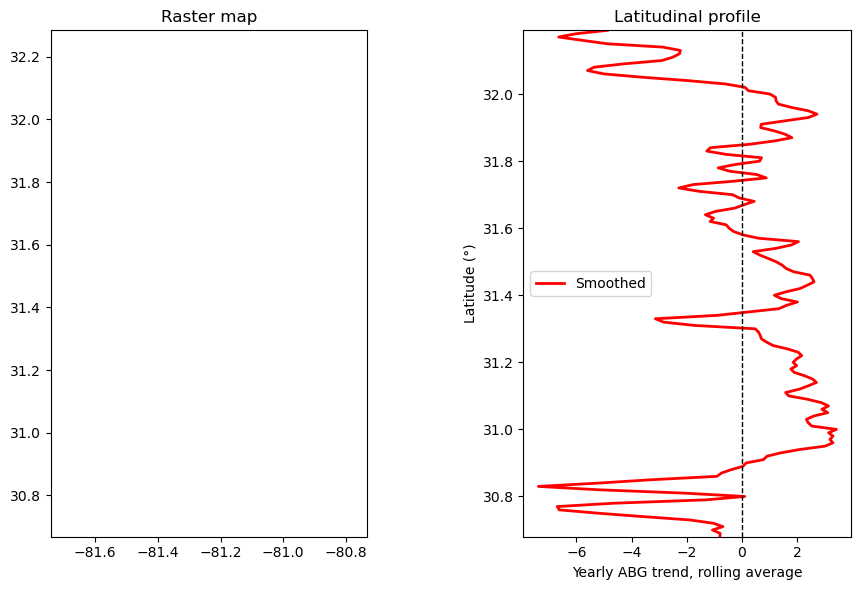

In [39]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

# --- PLOT SETUP ---
fig, (ax_map, ax_profile) = plt.subplots(
    ncols=2, figsize=(10,6),
    gridspec_kw={"width_ratios": [2, 1]}  # make map wider than profile
)

# --- LEFT PANEL: THE MAP ---
with rasterio.open("F:/Biomass tiffs/Biomass modeling/Georgia/All_trend/ALLGA_LOG_sig_1984to2023.tif") as src:
    arr = src.read(1, masked=True)   # first band, mask nodata automatically
    show(arr, transform=src.transform, ax=ax_map, cmap="viridis")
    bounds = src.bounds
ax_map.set_title("Raster map")

# --- RIGHT PANEL: LATITUDINAL PROFILE ---
# Center values on 0
lat_summary["centered"] = lat_summary["mean_val"] - lat_summary["mean_val"].mean()
lat_summary["roll_centered"] = lat_summary["roll_3bins"] - lat_summary["mean_val"].mean()

## Plot horizontal (x=centered, y=lat)
# ax_profile.plot(lat_summary["centered"], lat_summary["lat_bin"], 
#                 color="gray", alpha=0.7, label="Mean value")
ax_profile.plot(lat_summary["roll_centered"], lat_summary["lat_bin"], 
                color="red", linewidth=2, label="Smoothed")

# Flip so south at bottom, north at top
ax_profile.set_ylim(lat_summary["lat_bin"].min(), lat_summary["lat_bin"].max())

# Add a vertical line at 0 for reference
ax_profile.axvline(0, color="black", linestyle="--", linewidth=1)

ax_profile.set_xlabel("Yearly ABG trend, rolling average")
ax_profile.set_ylabel("Latitude (°)")
ax_profile.set_title("Latitudinal profile")
ax_profile.legend()

plt.tight_layout()
plt.show()



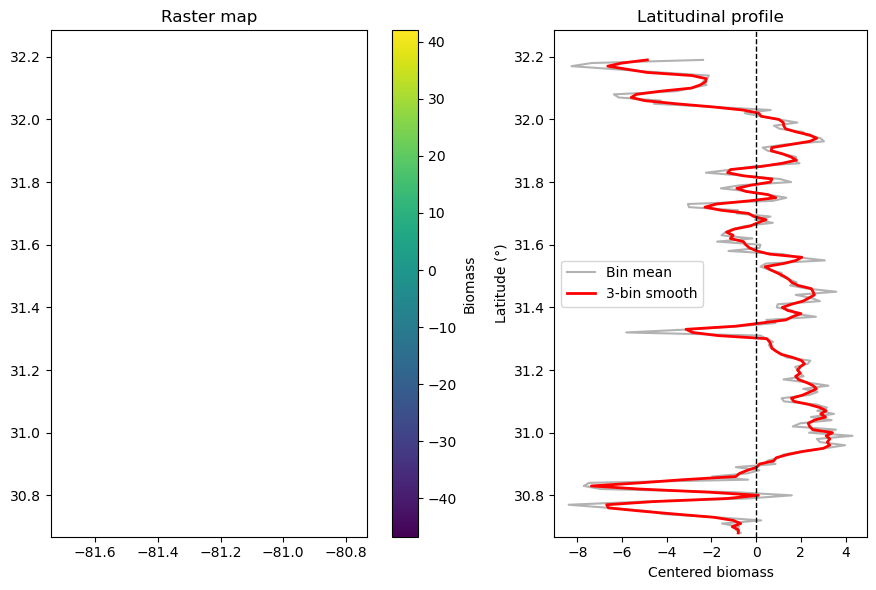

In [40]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Open raster and read first band ---
with rasterio.open("F:/Biomass tiffs/Biomass modeling/Georgia/All_trend/ALLGA_LOG_sig_1984to2023.tif") as src:
    arr = src.read(1, masked=True)   # first band, mask nodata
    bounds = src.bounds              # (left, bottom, right, top) = (minx, miny, maxx, maxy)

# --- Build latitudinal summary ---
rows, cols = np.where(~arr.mask)
vals = arr.data[rows, cols]
lons, lats = rasterio.transform.xy(src.transform, rows, cols)
lats = np.array(lats)

df = pd.DataFrame({"lat": lats, "value": vals})
df["lat_bin"] = (df["lat"] / 0.01).round().astype(int) * 0.01
lat_summary = (
    df.groupby("lat_bin")
      .agg(mean_val=("value","mean"), count=("value","count"))
      .reset_index()
      .sort_values("lat_bin")
)
lat_summary["roll"] = (
    lat_summary["mean_val"]
    .rolling(window=3, center=True, min_periods=1)
    .mean()
)

# Center values for plotting
lat_summary["centered"] = lat_summary["mean_val"] - lat_summary["mean_val"].mean()
lat_summary["roll_centered"] = lat_summary["roll"] - lat_summary["mean_val"].mean()

# --- Plot map + profile side by side ---
fig, (ax_map, ax_profile) = plt.subplots(
    ncols=2, figsize=(11,6),
    gridspec_kw={"width_ratios":[2,1]}
)

# Left: Map
im = ax_map.imshow(
    arr, cmap="viridis",
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
    origin="upper"
)
ax_map.set_title("Raster map")
plt.colorbar(im, ax=ax_map, fraction=0.046, pad=0.04, label="Biomass")

# Right: Latitudinal profile
ax_profile.plot(lat_summary["centered"], lat_summary["lat_bin"],
                color="gray", alpha=0.6, label="Bin mean")
ax_profile.plot(lat_summary["roll_centered"], lat_summary["lat_bin"],
                color="red", linewidth=2, label="3-bin smooth")

# Match profile y-axis with map latitude
ax_profile.set_ylim(bounds.bottom, bounds.top)

# Add vertical reference line at 0
ax_profile.axvline(0, color="black", linestyle="--", linewidth=1)

ax_profile.set_xlabel("Centered biomass")
ax_profile.set_ylabel("Latitude (°)")
ax_profile.set_title("Latitudinal profile")
ax_profile.legend()

plt.tight_layout()
plt.show()


ValueError: x and y must be the same size

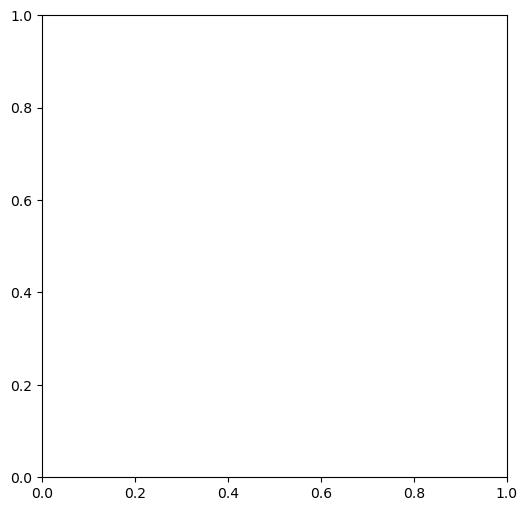

In [43]:
##FLATS+ trend vs. ABG trend (FLATS+ is a term in the RF model for abg)

import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open both rasters
with rasterio.open("F:/Biomass tiffs/Biomass modeling/Georgia/All_trend/ALLGA_LOG_sig_1984to2023.tif") as src1, rasterio.open("F:/Flats imagery/FLATS_trend_lowtide.tif") as src2:
    arr1 = src1.read(1, masked=True)
    arr2 = src2.read(1, masked=True)

# Ensure the grids match
if (src1.width != src2.width or src1.height != src2.height or src1.transform != src2.transform):
    raise ValueError("Rasters are not perfectly aligned!")

# Flatten arrays and mask out nodata
x = arr1.compressed()  # removes masked pixels
y = arr2.compressed()

# Scatterplot
plt.figure(figsize=(6,6))
plt.scatter(x, y, s=2, alpha=0.3)
plt.xlabel("ABG trend")
plt.ylabel("FLATS+ trend")
plt.title("Pixel-wise scatterplot")
plt.grid(True)
plt.show()
